# Bank Churn Prediction - Feature Engineering
## Creating and Transforming 52 Features for Model Training

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import mutual_info_classif
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
%matplotlib inline

In [3]:
# Load processed data
train_df = pd.read_csv('../data/processed/train_set.csv')
val_df = pd.read_csv('../data/processed/val_set.csv')
test_df = pd.read_csv('../data/processed/test_set.csv')

print("=== PROCESSED DATASETS ===")
print(f"Train set: {train_df.shape}")
print(f"Validation set: {val_df.shape}")
print(f"Test set: {test_df.shape}")
print(f"\nChurn rates - Train: {train_df['churn_risk'].mean():.2%}, "
      f"Val: {val_df['churn_risk'].mean():.2%}, Test: {test_df['churn_risk'].mean():.2%}")

=== PROCESSED DATASETS ===
Train set: (7000, 54)
Validation set: (1500, 54)
Test set: (1500, 54)

Churn rates - Train: 12.00%, Val: 12.00%, Test: 12.00%


In [4]:
# Feature types analysis
def analyze_feature_types(df):
    numerical = df.select_dtypes(include=[np.number]).columns.tolist()
    categorical = df.select_dtypes(include=['object']).columns.tolist()
    
    # Remove target and ID columns
    numerical = [col for col in numerical if col not in ['churn_risk', 'churn_probability', 'customer_id']]
    categorical = [col for col in categorical if col != 'customer_id']
    
    return numerical, categorical

numerical_features, categorical_features = analyze_feature_types(train_df)

print("=== FEATURE TYPES ===")
print(f"Numerical features: {len(numerical_features)}")
print(f"Categorical features: {len(categorical_features)}")
print(f"\nCategorical features: {categorical_features}")

=== FEATURE TYPES ===
Numerical features: 42
Categorical features: 9

Categorical features: ['region', 'occupation_type', 'customer_since', 'account_type', 'tenure_segment', 'age_group', 'income_bracket', 'education_level', 'marital_status']


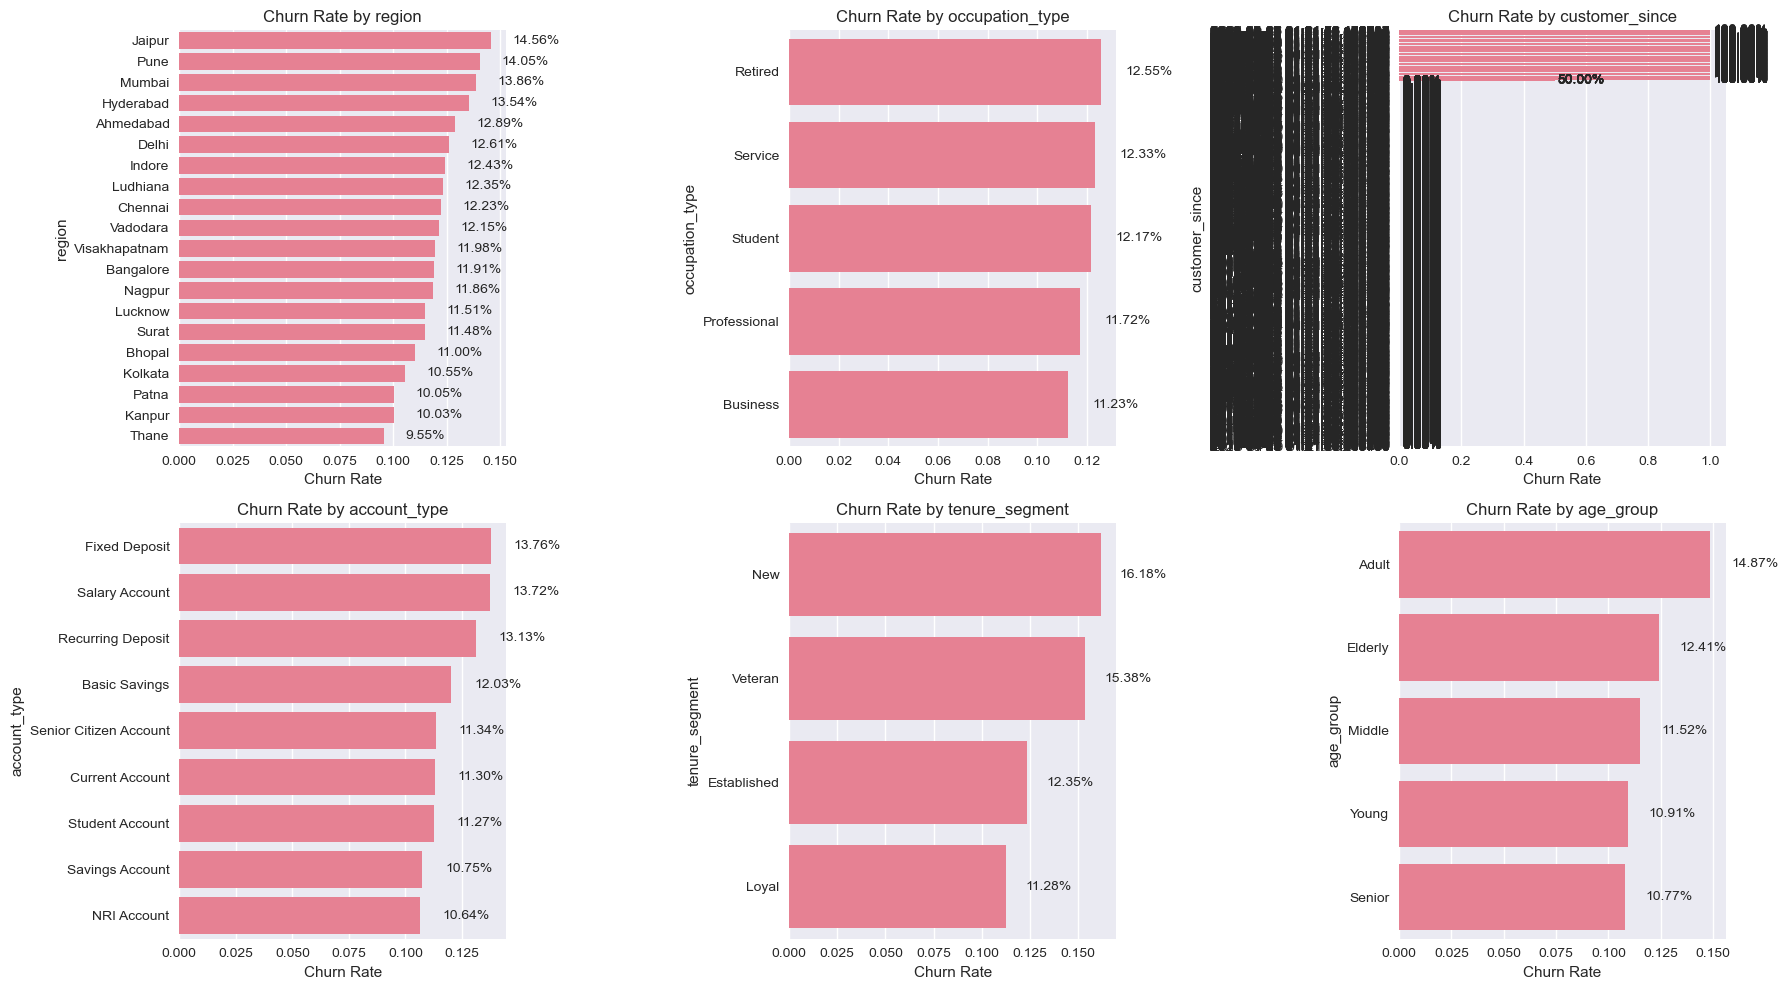

In [5]:
# Categorical feature analysis
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

categorical_to_plot = categorical_features[:6]  # Plot first 6 categorical features

for i, feature in enumerate(categorical_to_plot):
    if i < 6:
        row, col = i // 3, i % 3
        
        # Calculate churn rates by category
        churn_by_category = train_df.groupby(feature)['churn_risk'].mean().sort_values(ascending=False)
        
        # Plot
        sns.barplot(x=churn_by_category.values, y=churn_by_category.index, ax=axes[row, col])
        axes[row, col].set_title(f'Churn Rate by {feature}')
        axes[row, col].set_xlabel('Churn Rate')
        
        # Add value annotations
        for j, v in enumerate(churn_by_category.values):
            axes[row, col].text(v + 0.01, j, f'{v:.2%}', va='center')

# Hide empty subplots
for i in range(len(categorical_to_plot), 6):
    row, col = i // 3, i % 3
    axes[row, col].set_visible(False)

plt.tight_layout()
plt.show()

In [6]:
# Cardinality of categorical features
print("=== CATEGORICAL FEATURE CARDINALITY ===")
for feature in categorical_features:
    unique_count = train_df[feature].nunique()
    print(f"{feature}: {unique_count} unique values")

=== CATEGORICAL FEATURE CARDINALITY ===
region: 20 unique values
occupation_type: 5 unique values
customer_since: 6945 unique values
account_type: 9 unique values
tenure_segment: 4 unique values
age_group: 5 unique values
income_bracket: 4 unique values
education_level: 4 unique values
marital_status: 4 unique values


In [7]:
# Feature engineering: Create interaction features
def create_interaction_features(df):
    """Create meaningful interaction features"""
    df_eng = df.copy()
    
    # Engagement-to-balance ratio
    if 'activity_score' in df.columns and 'avg_account_balance' in df.columns:
        df_eng['engagement_balance_ratio'] = df['activity_score'] / (df['avg_account_balance'] + 1)
    
    # Fee burden relative to income
    if 'avg_monthly_fees' in df.columns and 'income' in df.columns:
        df_eng['fee_income_ratio'] = df['avg_monthly_fees'] / (df['income'] / 12 + 1)
    
    # Service efficiency (complaints per tenure)
    if 'num_complaints' in df.columns and 'tenure_months' in df.columns:
        df_eng['complaints_per_tenure'] = df['num_complaints'] / (df['tenure_months'] + 1)
    
    # Product utilization score
    if 'num_products' in df.columns and 'tenure_months' in df.columns:
        df_eng['products_per_tenure'] = df['num_products'] / (df['tenure_months'] + 1)
    
    return df_eng

# Apply feature engineering
train_eng = create_interaction_features(train_df)
val_eng = create_interaction_features(val_df)
test_eng = create_interaction_features(test_df)

print("Feature engineering completed!")
print(f"New features created: {[col for col in train_eng.columns if col not in train_df.columns]}")

Feature engineering completed!
New features created: ['engagement_balance_ratio', 'fee_income_ratio', 'complaints_per_tenure', 'products_per_tenure']


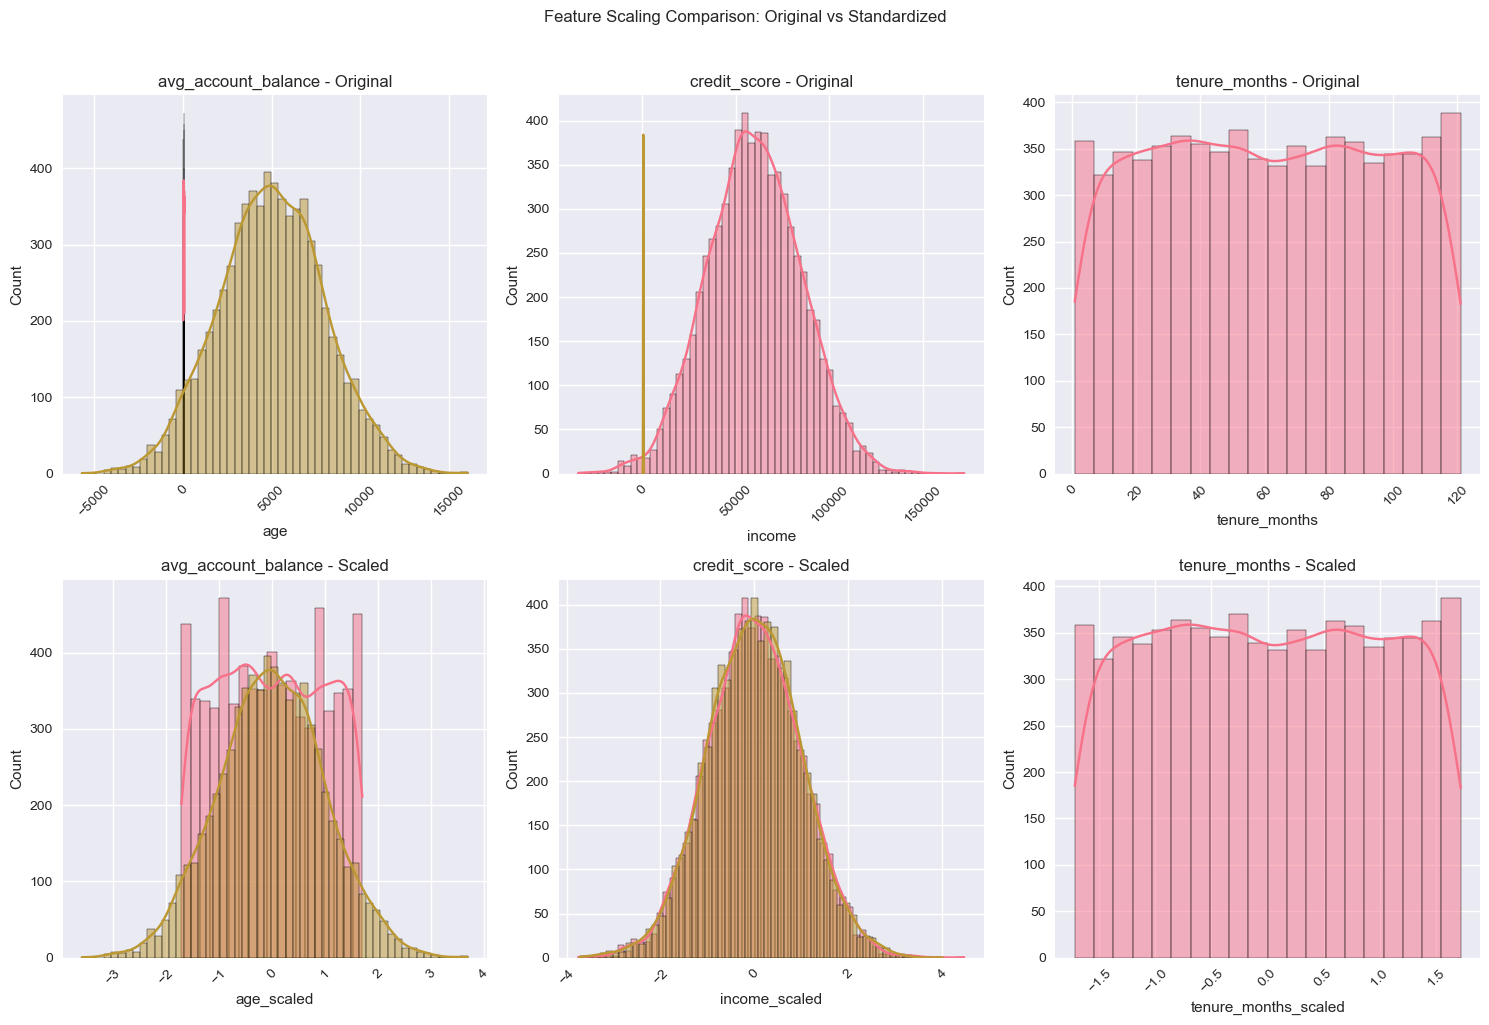

In [8]:
# Feature scaling demonstration
scaler = StandardScaler()

# Select key numerical features for scaling demonstration
demo_features = ['age', 'income', 'tenure_months', 'avg_account_balance', 'credit_score']
demo_features = [f for f in demo_features if f in numerical_features]

# Scale features
train_scaled = scaler.fit_transform(train_eng[demo_features])
train_scaled_df = pd.DataFrame(train_scaled, columns=[f'{col}_scaled' for col in demo_features])

# Create subplots with enough space for all features
n_features = len(demo_features)
n_rows = (n_features + 1) // 2  # Calculate needed rows for all features
fig, axes = plt.subplots(2, n_rows, figsize=(15, 10))

# Before scaling
for i, feature in enumerate(demo_features):
    row = i // n_rows
    col = i % n_rows
    sns.histplot(train_eng[feature], ax=axes[0, col], kde=True)
    axes[0, col].set_title(f'{feature} - Original')
    axes[0, col].tick_params(axis='x', rotation=45)

# After scaling
for i, feature in enumerate(demo_features):
    row = i // n_rows
    col = i % n_rows
    sns.histplot(train_scaled_df[f'{feature}_scaled'], ax=axes[1, col], kde=True)
    axes[1, col].set_title(f'{feature} - Scaled')
    axes[1, col].tick_params(axis='x', rotation=45)

# Hide empty subplots if any
for row in range(2):
    for col in range(n_features, n_rows):
        axes[row, col].set_visible(False)

plt.suptitle('Feature Scaling Comparison: Original vs Standardized', y=1.02)
plt.tight_layout()
plt.show()

In [9]:
# Categorical encoding demonstration
label_encoders = {}

# Label encode categorical features
train_encoded = train_eng.copy()
val_encoded = val_eng.copy()
test_encoded = test_eng.copy()

for feature in categorical_features:
    if feature in train_encoded.columns:
        le = LabelEncoder()
        train_encoded[feature] = le.fit_transform(train_encoded[feature].astype(str))
        
        # Handle unseen labels in validation/test
        val_encoded[feature] = val_encoded[feature].apply(
            lambda x: le.transform([x])[0] if x in le.classes_ else -1
        )
        test_encoded[feature] = test_encoded[feature].apply(
            lambda x: le.transform([x])[0] if x in le.classes_ else -1
        )
        
        label_encoders[feature] = le

print("Categorical encoding completed!")
print(f"Encoded {len(categorical_features)} categorical features")

Categorical encoding completed!
Encoded 9 categorical features


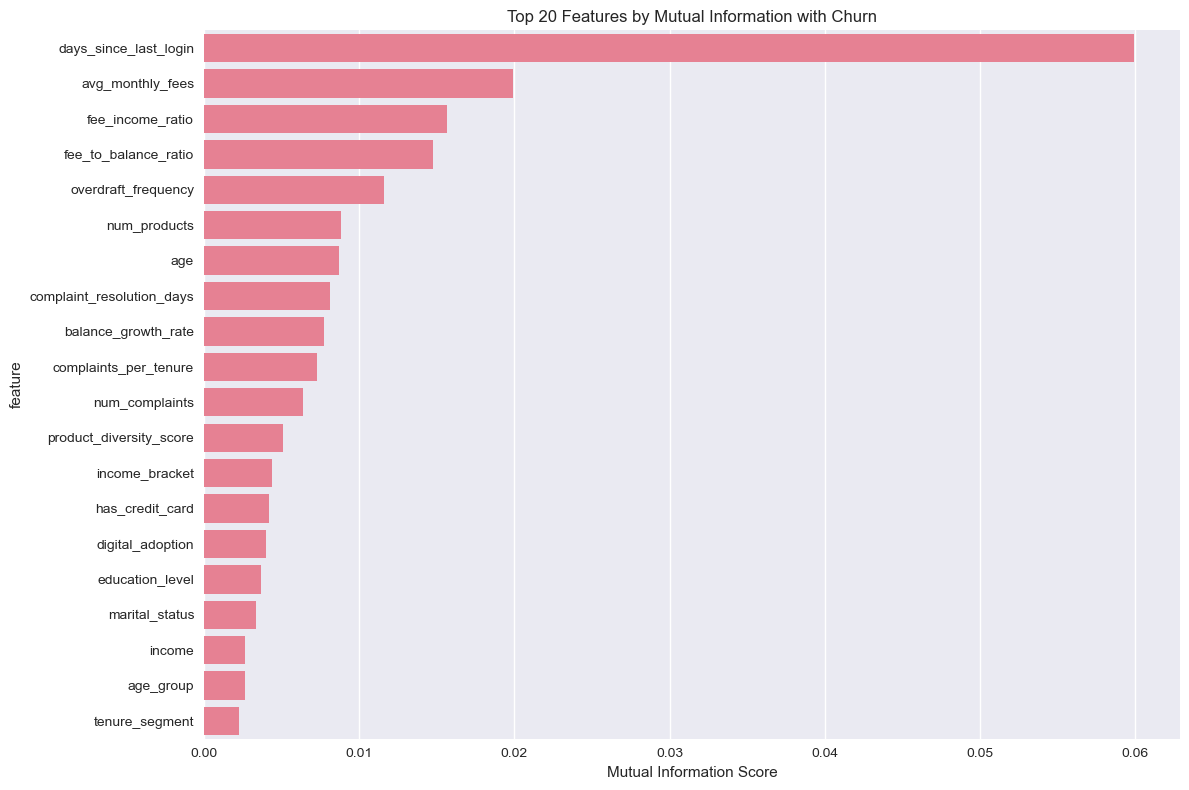

In [10]:
# Feature importance using mutual information
X_train = train_encoded.drop(columns=['churn_risk', 'churn_probability', 'customer_id'], errors='ignore')
y_train = train_encoded['churn_risk']

# Calculate mutual information
mi_scores = mutual_info_classif(X_train, y_train, random_state=42)
mi_scores_df = pd.DataFrame({
    'feature': X_train.columns,
    'mi_score': mi_scores
}).sort_values('mi_score', ascending=False)

# Plot top 20 features
plt.figure(figsize=(12, 8))
sns.barplot(data=mi_scores_df.head(20), x='mi_score', y='feature')
plt.title('Top 20 Features by Mutual Information with Churn')
plt.xlabel('Mutual Information Score')
plt.tight_layout()
plt.show()

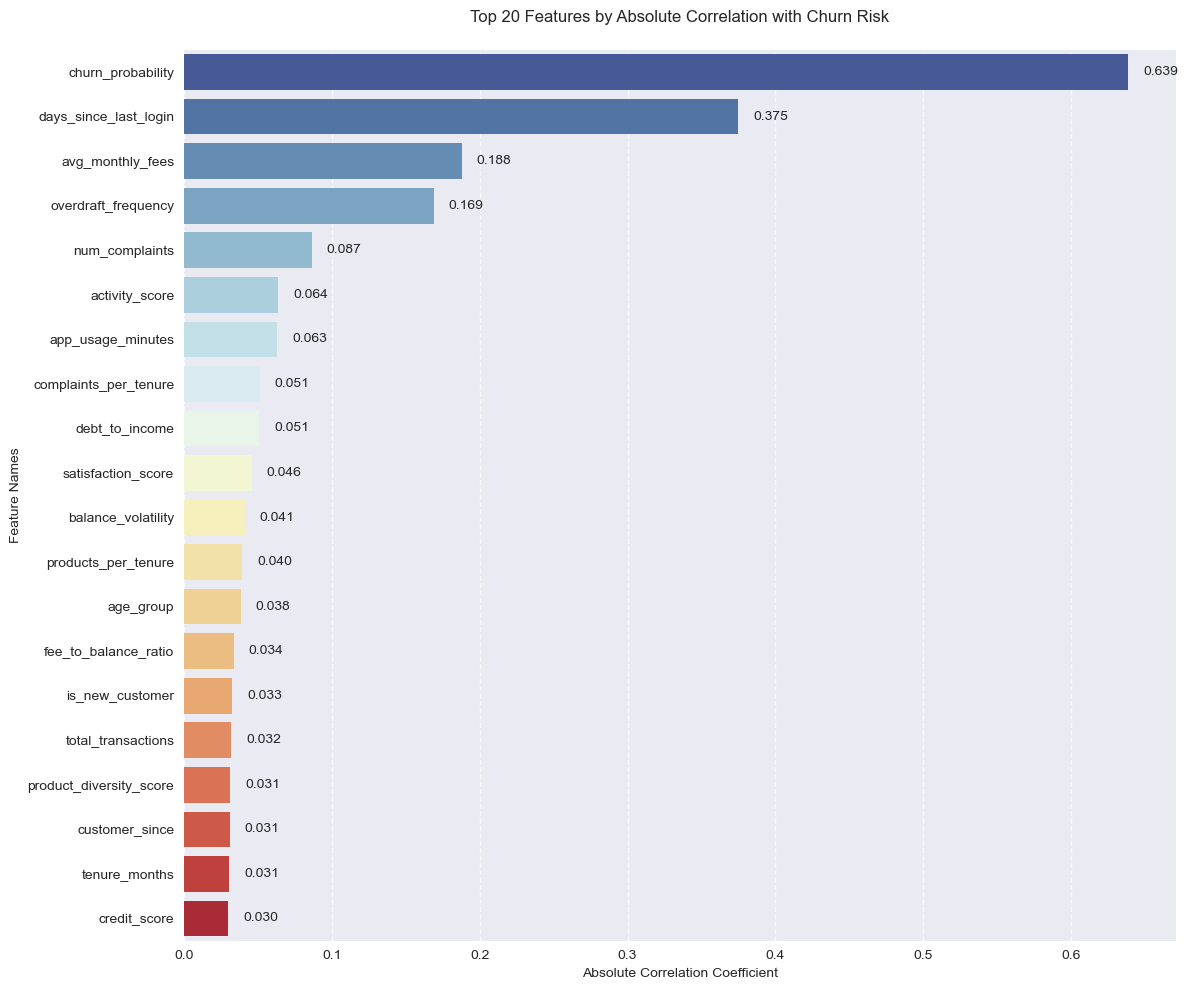


=== Correlation Statistics ===
Number of features with correlation > 0.3: 2
Number of features with correlation > 0.2: 2

Top 5 most correlated features:
churn_probability: 0.639
days_since_last_login: 0.375
avg_monthly_fees: 0.188
overdraft_frequency: 0.169
num_complaints: 0.087

Excluded non-numeric columns:
['customer_id']


In [11]:
# Feature correlation with target
# Get only numeric columns for correlation analysis
numeric_columns = train_encoded.select_dtypes(include=[np.number]).columns
correlation_with_target = train_encoded[numeric_columns].corr()['churn_risk'].abs().sort_values(ascending=False)
correlation_with_target = correlation_with_target[correlation_with_target.index != 'churn_risk']

# Plot top correlated features
plt.figure(figsize=(12, 10))
ax = sns.barplot(x=correlation_with_target.head(20).values, 
                y=correlation_with_target.head(20).index,
                palette='RdYlBu_r')  # Color gradient based on correlation strength

# Add value annotations
for i, v in enumerate(correlation_with_target.head(20).values):
    ax.text(v + 0.01, i, f'{v:.3f}', va='center')

# Customize the plot
plt.title('Top 20 Features by Absolute Correlation with Churn Risk', pad=20, fontsize=12)
plt.xlabel('Absolute Correlation Coefficient', fontsize=10)
plt.ylabel('Feature Names', fontsize=10)

# Add a grid for better readability
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()

# Print correlation statistics
print("\n=== Correlation Statistics ===")
print(f"Number of features with correlation > 0.3: {len(correlation_with_target[correlation_with_target > 0.3])}")
print(f"Number of features with correlation > 0.2: {len(correlation_with_target[correlation_with_target > 0.2])}")
print("\nTop 5 most correlated features:")
for feature, corr in correlation_with_target.head().items():
    print(f"{feature}: {corr:.3f}")

# Print excluded columns for reference
excluded_columns = set(train_encoded.columns) - set(numeric_columns)
if excluded_columns:
    print("\nExcluded non-numeric columns:")
    print(sorted(excluded_columns))

In [12]:
# Final feature matrix shape
final_features = [col for col in train_encoded.columns 
                 if col not in ['churn_risk', 'churn_probability', 'customer_id']]

print("=== FINAL FEATURE MATRIX ===")
print(f"Total features: {len(final_features)}")
print(f"Training set shape: {train_encoded[final_features].shape}")
print(f"Validation set shape: {val_encoded[final_features].shape}")
print(f"Test set shape: {test_encoded[final_features].shape}")

# Feature categories in final matrix
feature_categories = {
    'Demographics': len([f for f in final_features if any(x in f for x in ['age', 'income', 'region', 'occupation', 'education', 'marital', 'family'])]),
    'Engagement': len([f for f in final_features if any(x in f for x in ['transaction', 'login', 'activity', 'usage', 'calls', 'frequency'])]),
    'Fees': len([f for f in final_features if any(x in f for x in ['fee', 'overdraft', 'penalty', 'charge'])]),
    'Service': len([f for f in final_features if any(x in f for x in ['complaint', 'satisfaction', 'service', 'resolution', 'escalation'])]),
    'Products': len([f for f in final_features if any(x in f for x in ['product', 'credit_card', 'mortgage', 'investment', 'insurance'])]),
    'Tenure': len([f for f in final_features if any(x in f for x in ['tenure', 'customer_since', 'new_customer', 'segment'])]),
    'Balance': len([f for f in final_features if any(x in f for x in ['balance', 'salary', 'volatility', 'withdrawal'])]),
    'Credit': len([f for f in final_features if any(x in f for x in ['credit', 'debt', 'loan', 'inquiry', 'default'])]),
    'Personalization': len([f for f in final_features if any(x in f for x in ['promotion', 'reward', 'offer', 'personalized', 'relevance'])]),
    'Contract': len([f for f in final_features if any(x in f for x in ['account_age', 'maturity', 'renewal', 'closure', 'status'])]),
    'Engineered': len([f for f in final_features if any(x in f for x in ['ratio', 'per_tenure', 'interaction'])])
}

print("\n=== FEATURE CATEGORY BREAKDOWN ===")
for category, count in feature_categories.items():
    print(f"{category}: {count} features")

=== FINAL FEATURE MATRIX ===
Total features: 55
Training set shape: (7000, 55)
Validation set shape: (1500, 55)
Test set shape: (1500, 55)

=== FEATURE CATEGORY BREAKDOWN ===
Demographics: 14 features
Engagement: 7 features
Fees: 6 features
Service: 7 features
Products: 7 features
Tenure: 6 features
Balance: 8 features
Credit: 6 features
Personalization: 3 features
Contract: 1 features
Engineered: 6 features


## Feature Engineering Summary:

1. **Feature Types**: Successfully identified and processed numerical and categorical features
2. **Encoding**: Applied appropriate encoding strategies for categorical variables
3. **Scaling**: Demonstrated feature scaling for numerical variables
4. **Feature Importance**: Identified most predictive features using mutual information
5. **Final Matrix**: Created comprehensive feature matrix ready for modeling

**Next Steps**: Proceed to model training with the engineered features.